# SAT Solving for Pairwise Methods


This is a notebook for Appendix B of the paper "An approach to generalizing some impossibility theorems in social choice" by Wesley H. Holliday, Eric Pacuit, and Saam Zahedian.  


We use a SAT solver to prove that anonymity, neutrality, quasi-resoluteness, and binary $\gamma$ are inconsistent.

## Notebook Overview
1. **Canonical weighted tournament solutions** 
    1. Canonical weighted tournaments
    2. Orbit condition
2. **SAT setup**
    1. Winning set dictionary
    2. Functionality
3. **Quasi-resoluteness**
4. **Binary $\gamma$**
    1. Weighted tournament embeddings
    2. Weighted tournament embedding example
    3. Generate weighted tournament embeddings
    4. Form clauses
4. **Demonstration of Theorem B.3**

In [1]:
from itertools import product, combinations, permutations
import pickle
import networkx as nx # for graphs
import matplotlib.pyplot as plt
from pysat.solvers import Glucose3 # SAT solver
from copy import deepcopy
from scipy.special import comb

In [2]:
# helper functions

def display_wwt(wwt, edge_attr):
    """Display a weighted (weak) tournament with edge weights"""
    pos = nx.circular_layout(wwt)
    nx.draw(wwt, pos, font_size=20, node_color='blue', font_color='white',
            node_size=700, width=1, with_labels=True)
    
    edge_labels = nx.get_edge_attributes(wwt, edge_attr)
    nx.draw_networkx_edge_labels(wwt, pos, edge_labels=edge_labels, label_pos=0.3)
    plt.show()

def is_maj_preferred(wt, c1, c2): 
    """True if c1 is majority preferred to c2"""
    return wt.has_edge(c1, c2)

def is_tournament(wt):
    """test if a weak tournament is a tournament"""
    candidates = wt.nodes
    is_t = True
    for c1 in candidates: 
        for c2 in candidates: 
            if c1 != c2 and not is_maj_preferred(wt,c1,c2) and not is_maj_preferred(wt,c2,c1):
                is_t = False
    return is_t

def findsubsets(s, n):
    """all subsets of the list s of size n""" 
    return [set(i) for i in combinations(s, n)] 

def powerset_ne(fullset):
    """return all non-empty subsets of fullset"""
    listrep = list(fullset)
    n = len(listrep)
    all_subsets = [[listrep[k] for k in range(n) if i&1<<k ] for i in range(2**n)]
    return [s for s in all_subsets if len(s) > 0]

def all_included(listlike, items):
    """
    helper for powerset_ne_plus
    returns true if all members of items are in listlike
    """
    for item in items:
        if item not in listlike:
            return False
    return True

def powerset_ne_plus(listlike, items):
    """returns all non-empty subsets of setlike which include elements of items"""
    return [pset for pset in powerset_ne(listlike) if all_included(pset, items)]

def ways(weight_domain, num):
    return [x for x in combinations(weight_domain, int(num))]

## 1. Canonical weighted tournament solutions

### A. Canonical weighted tournaments

To see how the canonical weighted tournaments are generated, see the notebook Canonical_Tournaments.ipynb.

In [3]:
# Only consider tournaments for up to 4 candidates
numbers_of_candidates = [2, 3, 4]

# name of networkx edge attribute storing each edge's weight
edge_attr = 'weight'

# possible weights on edges
weight_domain = [2, 4, 6, 8, 10, 12]

def edge_compare_helper(dict1, dict2, edge_attr):
    return dict1[edge_attr] == dict2[edge_attr]

edge_compare = (lambda edge_attr: lambda dict1, dict2: edge_compare_helper(dict1, dict2, edge_attr))(edge_attr)

# Paths to pickled weak tournaments
canonical_weighted_tournament_paths = {
    2: 'weighted_tourns/weighted_tourns_2.pkl',
    3: 'weighted_tourns/weighted_tourns_3.pkl',
    4: 'weighted_tourns/weighted_tourns_4.pkl',
}

# Load all the canonical weak tournaments
canonical_weighted_tournaments = {nc: pickle.load(open(canonical_weighted_tournament_paths[nc], 'rb')) \
                                  for nc in numbers_of_candidates}

print("Done loading canonical weighted tournaments.\n")

for nc in numbers_of_candidates: 
    print(f"There are {len(canonical_weighted_tournaments[nc])} canonical weighted tournaments for {nc} candidates")


Done loading canonical weighted tournaments.

There are 6 canonical weighted tournaments for 2 candidates
There are 160 canonical weighted tournaments for 3 candidates
There are 1920 canonical weighted tournaments for 4 candidates


### B. Orbit condition

Ensuring the orbit condition is satisfied on weighted tournaments is similar to doing so for tournament solutions. The only difference is that isomorphisms and canonical representatives now involve edge weights.

In [4]:
def orbit_condition(orbit, ws): 
    """
    orbit is a set of candidates and ws is a winning set
    returns true if the orbit condition is satisfied
    """
    return set(orbit).issubset(set(ws)) or not bool(set(orbit).intersection(set(ws)))

def find_possible_winners(min_num_cands, max_num_cands, canonical_graphs): 
    """
    takes dictionary of canonical graphs and range of graph sizes to consider
    for each canonical graph, creates tuples containing the graph and winning sets that meet the orbit condition
    """
    possible_winners = {nc: list() for nc in range(min_num_cands, max_num_cands + 1)}
    for nc in possible_winners.keys():
        for g in canonical_graphs[nc]:
            candidates = g.nodes

            # all the automorophism on wt
            automorphisms = list(nx.algorithms.isomorphism.GraphMatcher(g, g, edge_match=edge_compare).isomorphisms_iter())

            # find the orbits
            _orbits=list()
            for c in candidates: 
                _orbit = list()
                for aut in automorphisms: 
                    _orbit.append(aut[c])
                _orbits.append(tuple(set(_orbit)))
            orbits = list(set(_orbits))

            # find the possible winning sets for wt
            for ws in powerset_ne(candidates): 
                if all([orbit_condition(orbit, ws) for orbit in orbits]):
                    possible_winners[nc].append((g, ws))
    return possible_winners

## 2. SAT setup

We use the [PySAT](https://pysathq.github.io/) toolkit to interface with a SAT solver. Formulas in PySAT are written in conjunctive normal form. Disjunctions are written as lists of integers. A positive integer denotes a propositional variable, a negative integer its negation.

For a canonical weighted tournament $T_C$ and a possible winning set $Y$, let $A_{T_C,Y}$ be a propositional variable, where
$A_{T_C,Y}$ means that $Y$ is the winning set associated with $T_C$ and  $\neg A_{T_C,Y}$ means that $Y$ is not the winning set associated with $T_C$.

### A.  Winning set dictionary



In [5]:
def generate_wwt_dictionary(possible_winners):
    """
    takes a dictionary of (weak) tournaments and returns a dictionary (t, ws) -> int
    t is a tournament in 'possible_winners' and ws is a winning set on t satisfying the orbit condition
    """
    wwt_dictionary = {}
    wwt_id = 1
    for nc in possible_winners.keys(): 
        for wwt,ws in possible_winners[nc]:
            wwt_dictionary.update({(wwt, tuple(ws)): wwt_id})
            wwt_id += 1
    return wwt_dictionary

### B. Functionality

The first step is to write a list of clauses expressing functionality. The concept is that for each weighted weak tournament $T$, some possible winning set is associated with $T$, and it is not the case that two winning sets are associated with $T$.

For instance, suppose that $T$ is a weighted tournament and there are three possible winning sets for $T$,  $Y_1$, $Y_2$ and $Y_3$. We add the following conjuncts to the formula: 

1. $A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}$
2. $\neg A_{T,Y_1}\vee \neg A_{T,Y_2}$
3. $\neg A_{T,Y_1}\vee \neg A_{T,Y_3}$
4. $\neg A_{T,Y_2}\vee \neg A_{T,Y_3}$.

The conjunction of these formulas says that exactly one of formulas $A_{T,Y_1}$, $A_{T, Y_2}$ or $A_{T, Y_3}$ is true: 

$$(A_{T,Y_1}\vee A_{T,Y_2}\vee A_{T,Y_3}) \wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_2})\wedge (\neg A_{T,Y_1}\vee \neg A_{T,Y_3})\wedge (\neg A_{T,Y_2}\vee \neg A_{T,Y_3}).$$

Then the above formula means that exactly one of $Y_1$, $Y_2$ or $Y_3$ is the winning set associated with $T$. 

In [6]:
def generate_function_formula(graphs, wwt_dictionary): 
    """
    takes a list of all graphs 'graphs' and a dictionary of possible winners on those graphs 'wwt_dictionary'
    returns CNF clauses ensuring that only one winning set will be chosen per graph
    """
    C_func = list()
    for g in graphs:     
        # get the list of all atomic formulas describing a possible winning set
        poss_ws = [wwt_dictionary[(_g, ws)] for _g,ws in wwt_dictionary.keys() if _g == g]
        # NOTE: we use equality rather than testing for graph isomporphism.  This makes sense since
        # graphs is the set of the networkx objects representing the canonical tournaments and 
        # the keys of wwt_dictionary are tuples where the first components is an object from this lest. 
        C_func.append(poss_ws) # one of the possible winning sets is the winner
        for pairs in combinations(poss_ws, 2):
            # add a clause saying that it is not the case that two possible winning sets are associated 
            # with a weighted tournament
            C_func.append([0 - pairs[0], 0 - pairs[1]])

    return C_func

In [7]:
# Sanity check: This should output True since it is always possible 
# to find some weighted tournament solution on a domain of weighted tournaments

min_num_cands, max_num_cands = 3, 4

canonical_graphs = canonical_weighted_tournaments
graphs = [wwt for nc in range(min_num_cands, max_num_cands + 1)  for wwt in canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wwt_dictionary = generate_wwt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wwt_dictionary)
print("Done creating the function formula.\n\n")

sat_solver = Glucose3()
for cl in C_func:
    sat_solver.add_clause(cl)
print(f"Should be true expressing that there is a weighted tournament solution on the domain: {sat_solver.solve()}\n")

# uncomment to see the model (list of literals that are true)
#print(sat_solver.get_model())

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.


Should be true expressing that there is a weighted tournament solution on the domain: True



## 3. Quasi-resoluteness

The quasi-resoluteness axiom states that if a weighted tournament's weights are distinct, then that tournament has a unique winner.

In [8]:
def unique_weights(g, edge_attr):
    """
    determines if a graph g has unique edge weights
    """
    if len(set([g.edges[e][edge_attr] for e in g.edges])) < len(g.edges):
        return False
    return True

def generate_qr_formula(wwt_dictionary, edge_attr):
    C_qr = list()
    for t, ws in wwt_dictionary.keys():
        if unique_weights(t, edge_attr) and len(ws) > 1:
            C_qr.append([-wwt_dictionary[(t, ws)]])
    return C_qr

## 4. Binary $\gamma$

### A. Weighted tournament embeddings

Note that we use "embedding" as it is used in model theory, which is equivalent to being isomorphic to a substructure (see W. Hodges, "Model Theory", pp. 5-6). A canonical weighted tournament $T'$ is a substructure of the canonical weighted tournament $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and for any candidates $x, y$ in $T'$, there is an edge from $x$ to $y$ in $T'$ with weight $n$ if and only if there is an edge from $x$ to $y$ with weight $n$ in $T$.

[Networkx](https://networkx.org/documentation/stable/reference/algorithms/isomorphism.vf2.html#digraph-matcher) has an algorithm to find isomorphisms from *subgraphs* of $T$ to a graph $T'$.  However, what networkx means by a "subgraph" is not the same as a substructure.   A canonical weak tournament $T'$ is a *subgraph* of $T$ when the set of candidates of $T'$ is a subset of the set of candidates of $T$ and  for any candidates $x, y$ in $T'$, if there is an edge from $x$ to $y$ in $T'$, then there is an edge from $x$ to $y$ in $T$. 

A subgraph isomorphism is not sufficient for a tournament embedding. We solve that problem by running subgraph isomorphisms through the function below.

In [9]:
def is_embedding(small_g, big_g, iso):
    """
    iso is an isomorphism from small_g to a subgraph of big_g,
    but we must check whether iso is an embedding. 
    returns True if iso is an embedding of small_g into big_g. 
    
    Returns True if for every pair of candidates c1 and c2 in small_g, 
    if there is an edge between iso[c1] and iso[c2] in big_g, then 
    there is an edge between c1 and c2 in small_g
    """
    for c1, c2 in product(small_g.nodes, small_g.nodes): 
        if big_g.has_edge(iso[c1],iso[c2]) and not small_g.has_edge(c1,c2):
            return False
    return True    

A verified _tournament_ embedding is not necessarily a _weighted tournament_ embedding. The function below checks whether a verified tournament embedding also preserves edge weights and is thus a weighted tournament embedding.

In [10]:
# helper function that transforms edges under an isomorphism
edge_conv = lambda e, iso: (iso[e[0]], iso[e[1]])

def preserves_weights(small_g, big_g, iso, edge_attr, verbose=False):
    """
    takes weighted tournament small_g, big_g and an embedding iso from small_g to big_g
    returns true if iso preserves weights from small_g to big_g
    """
    for e in small_g.edges:
        if small_g.edges[e][edge_attr] != big_g.edges[edge_conv(e, iso)][edge_attr]:
            if verbose:
                print("The edge {} in the small graph embeds into the edge {} in the big graph, but the weight of {} in the small graph doesn't match the weight of {} in the big graph.".format(e, edge_conv(e, iso), e, edge_conv(e, iso)))
            return False
    return True

### B. Weighted tournament embedding example

Run the  following code to illustrate the definition of a weighted tournament embedding and why a tournament embeddings is not necessarily a weighted tournament embedding.  

T1: a canonical weighted tournament for 4 candidates: 


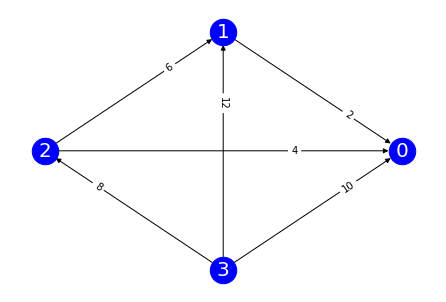

T2: a canonical weighted tournament for 3 candidates: 


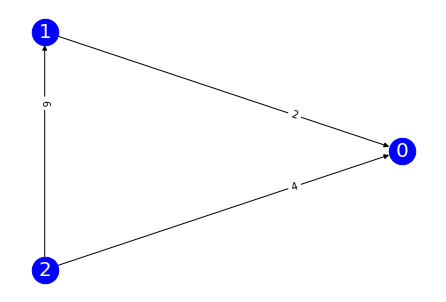

All the tournament embeddings between the weighted tournament T2 with 3 candidates and subgraphs of the weighted tournament T1 with 4 candidates:

e(0) = 0, e(1) = 1, e(2) = 2
	This tournament embedding is also a weighted tournament embedding.


e(0) = 0, e(1) = 1, e(2) = 3
The edge (2, 0) in the small graph embeds into the edge (3, 0) in the big graph, but the weight of (2, 0) in the small graph doesn't match the weight of (3, 0) in the big graph.
	So this tournament embedding is not a weighted tournament embedding.


e(0) = 0, e(1) = 2, e(2) = 3
The edge (1, 0) in the small graph embeds into the edge (2, 0) in the big graph, but the weight of (1, 0) in the small graph doesn't match the weight of (2, 0) in the big graph.
	So this tournament embedding is not a weighted tournament embedding.


e(0) = 1, e(1) = 2, e(2) = 3
The edge (1, 0) in the small graph embeds into the edge (2, 1) in the big graph, but the weight of (1, 0) in the small graph doesn't match the weight of (2, 1) in the 

In [11]:
T1 = canonical_weighted_tournaments[4][3]

print("T1: a canonical weighted tournament for 4 candidates: ")
display_wwt(T1, edge_attr)

print("T2: a canonical weighted tournament for 3 candidates: ")
T2 = canonical_weighted_tournaments[3][0]
display_wwt(T2, edge_attr)

print("All the tournament embeddings between the weighted tournament T2 with 3 candidates and subgraphs of the weighted tournament T1 with 4 candidates:\n")
for iso in nx.algorithms.isomorphism.GraphMatcher(T1, T2).subgraph_isomorphisms_iter():
    # iso is a dictionary mapping a subset of elements of the bigger graph T1 to the 
    # small graph T2, but it is easier to think about the inverse function mapping 
    # nodes in the small graph T2 into the bigger graph T1. 
    inverse_iso = {v:k for k,v in iso.items()}
    
    if not is_embedding(T2, T1, inverse_iso):
        continue
    
    print(", ".join([f"e({c1}) = {c2}" for c1, c2 in inverse_iso.items()]))
    
    if preserves_weights(T2, T1, inverse_iso, edge_attr, verbose=True):
        print("\tThis tournament embedding is also a weighted tournament embedding.\n\n")
    else:
        print("\tSo this tournament embedding is not a weighted tournament embedding.\n\n")

### C. Generate weighted tournament embeddings

Find all weighted tournament embeddings between canonical weighted tournaments of size $n$ and canonical weighted tournaments of size $n+1$. 

In [12]:
def find_embeddings_g1_g2(g1, g2, edge_attr):
    embeddings = list()
    
    seen_ranges = set()

    for iso in nx.algorithms.isomorphism.GraphMatcher(g2, g1, edge_match=edge_compare).subgraph_isomorphisms_iter():
        # for each isomporphism from g1 to a subgraph of g2

        # NOTE: iso is a dictionary associating a subset of nodes from g2 to the nodes in g1
        # It's easier to think about the isomorphism as a mapping from the smaller graph g1 
        # into the bigger graph g2:
        inverse_iso = {v:k for k,v in iso.items()}

        rng = tuple(sorted(iso.keys())) # the range of the isomorphism (nodes in the bigger graph)
        if not rng in seen_ranges and is_embedding(g1, g2, inverse_iso) and \
        preserves_weights(g1, g2, inverse_iso, edge_attr):
            # if haven't seen the range yet, g1 is an embedding into g2, 
            # and the embedding preserves edge weights
            seen_ranges.add(rng)
            # record the smaller graph g1, larger graph g2 and isomorphism from g1 to g2
            embeddings.append((g1, g2, inverse_iso))
            
    return embeddings

In [13]:
def find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr):
    """
    find embeddings of graphs in 'canonical_graphs',
    embeddings of n-tournaments to (n+1)-tournaments, for n=min_num_cands,...,max_num_cands-1
    """
    embeddings = list()

    for nc in range(min_num_cands, max_num_cands): 
        # for each number of candidate between min_num_cands and max_num_cands - 1  

        for g1 in canonical_graphs[nc]: 
            # for each canonical graph of size nc    

            for g2 in canonical_graphs[nc+1]:
                # for each canonical graph of size nc+1

                embeddings += find_embeddings_g1_g2(g1, g2, edge_attr)
                
    return embeddings

In [14]:
def find_embeddings_2(max_num_cands, canonical_graphs, edge_attr):
    embeddings_2 = list()
    
    for g1 in canonical_graphs[2]:
        for nc in range(3, max_num_cands+1):
            for g2 in canonical_graphs[nc]:
                embeddings_2 += find_embeddings_g1_g2(g1, g2, edge_attr)
                
    return embeddings_2

### D. Form clauses

In [15]:
def generate_bg_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wt_dictionary, 
                         possible_winners, 
                         embeddings,
                         embeddings_2): 
    """
    returns CNF clauses expressing binary gamma
    """

    C_bg = list()

    for nc in range(min_num_cands, max_num_cands+1):

        for t in canonical_graphs[nc]:
            # for each canonical graph on nc candidates
            
            E_t = [_emb for _emb in embeddings if _emb[1] == t]
            F_t = [_emb for _emb in embeddings_2 if _emb[1] == t]
            for emb in E_t: 
                # for each embedding into t from canonical graph emb[0]
                
                t_prime, _, e = emb 
                # t_prime is a canonical graph on nc-1 candidates, which t embeds into
                
                new_cand = list(set(t.nodes).difference(set(e.values())))[0]

                #new_cand = list(set(emb[1].nodes).difference(set(emb[2].values())))[0]
                # new_cand is the candidate in t1 not in the range of the embedding from t_prime to t
                
                restricted_F_t = [_emb for _emb in F_t if new_cand in set(_emb[2].values())]
                
                for emb_2 in restricted_F_t:
                    # for each embedding into t from canonical 2-candidate graph emb_2[0]
                    
                    t_dblprime, _, f = emb_2
                    
                    a = list(set(e.values()).intersection(f.values()))[0]
                    
                    a_preimage_in_t_prime = [t_prime_cand for t_prime_cand, t_cand in e.items() 
                                             if t_cand == a][0]
                    a_preimage_in_t_dblprime = [t_dblprime_cand for t_dblprime_cand, t_cand in f.items()
                                             if t_cand == a][0]
                    
                    if (t_dblprime, tuple([a_preimage_in_t_dblprime])) in wt_dictionary:
                        A_t_dblprime = wt_dictionary[(t_dblprime, tuple([a_preimage_in_t_dblprime]))]

                        for A_t_prime in [wt_dictionary[t_prime, tuple(_ws)] 
                                          for _ws in powerset_ne_plus(t_prime.nodes, [a_preimage_in_t_prime])
                                          if (t_prime, tuple(_ws)) in wt_dictionary]:
                            clause = [-A_t_prime, -A_t_dblprime]
                            clause += [wt_dictionary[t, tuple(_ws)]
                                      for _ws in powerset_ne_plus(t.nodes, [a])
                                      if (t, tuple(_ws)) in wt_dictionary]

                            C_bg.append(clause)
                        
            
    return C_bg

## 5. Demonstration of Theorem B.3

In [16]:
min_num_cands,max_num_cands = 2, 4

canonical_graphs = canonical_weighted_tournaments
graphs = [mg for nc in range(min_num_cands, max_num_cands + 1) for mg in  canonical_graphs[nc]]

possible_winners = find_possible_winners(min_num_cands, max_num_cands, canonical_graphs)
print("Done finding the possible winners.")

wwt_dictionary = generate_wwt_dictionary(possible_winners)
print("Done creating the encoding.")

C_func = generate_function_formula(graphs, wwt_dictionary)
print("Done creating the function formula.")

C_qr = generate_qr_formula(wwt_dictionary, edge_attr)
print("Done creating the quasi-resoluteness formula.")

embeddings = find_embeddings(min_num_cands, max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings.")

embeddings_2 = find_embeddings_2(max_num_cands, canonical_graphs, edge_attr)
print("Done creating the embeddings_2.")

Done finding the possible winners.
Done creating the encoding.
Done creating the function formula.
Done creating the quasi-resoluteness formula.
Done creating the embeddings.
Done creating the embeddings_2.


In [17]:
C_bg = generate_bg_formula(min_num_cands, 
                         max_num_cands, 
                         canonical_graphs, 
                         wwt_dictionary, 
                         possible_winners, 
                         embeddings,
                         embeddings_2)
print("Done creating the BG clauses")

Done creating the BG clauses


In [18]:
formula =  C_func + C_qr + C_bg
sat_solver = Glucose3()
for cl in formula:
    sat_solver.add_clause(cl)

if sat_solver.solve(): 
    print(f"There is a canonical weighted tournament solution up to {max_num_cands} candidates satisfying quasi-resoluteness and binary gamma.")
else: 
    print(f"There is no canonical weighted tournament solution up to {max_num_cands} candidates satisfying quasi-resoluteness and binary gamma.")

# uncomment to see the modle (list of literals that are true)
#print(sat_solver.get_model())
vm = sat_solver.get_model()

There is no canonical weighted tournament solution up to 4 candidates satisfying quasi-resoluteness and binary gamma.
